In [1]:
import numpy as np
import pandas as pd
import lib_svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load and inspect the data

In [2]:
dataset = lib_svm.read_data()

### Get TF-IDF vectorizers and datasets

In [3]:
tfidf_vectorizer = dataset['tfidf']
x_train, x_test, y_train, y_test = dataset['data']

In [4]:
x_train.shape, x_test.shape

((213205, 89461), (53302, 89461))

### Correlation analysis - ${\chi}^2$ score calculation

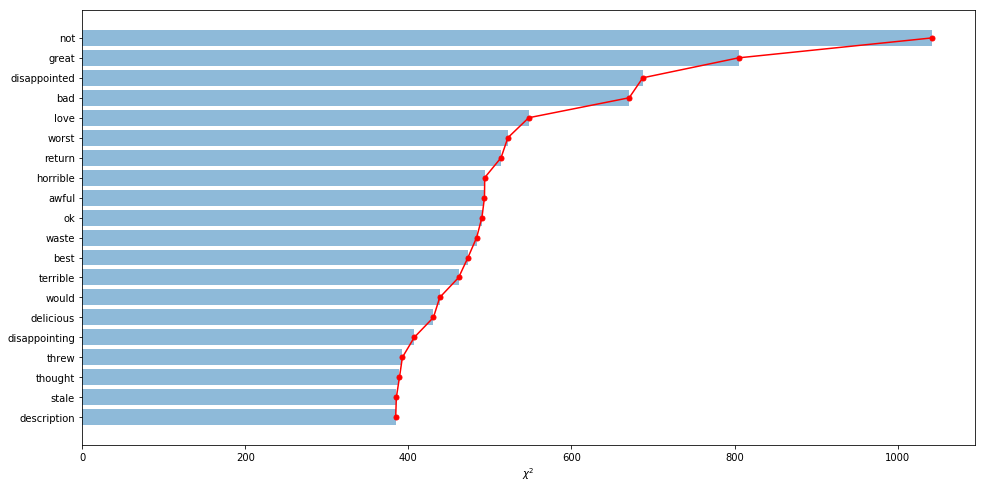

In [5]:
chi2score = chi2(x_train, y_train)[0]
plt.figure(figsize=(16, 8))
scores = list(zip(tfidf_vectorizer.get_feature_names(), chi2score))
sorted_chi2 = sorted(scores, key=lambda x: x[1])
topchi2 = list(zip(*sorted_chi2[-20: ]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, color='r')
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show()

# Compare Various Classification Models

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

### Cross validation

In [7]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


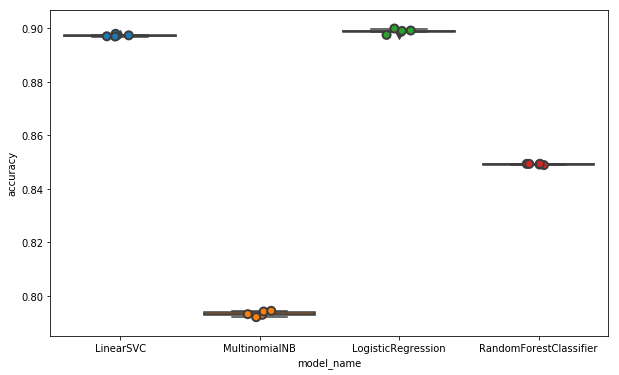

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="model_name", y="accuracy", data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# Build a SVM Classifier

### Choose appropriate C using Grid Search

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.5, 0.8, 1.0, 1.5]
}

svm = LinearSVC(max_iter=1500)
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(x_train, y_train)
print("Best Parameters :", svm_cv.best_params_)
print("Best Score :",svm_cv.best_score_)

Best Parameters : {'C': 0.5}
Best Score : 0.8998147322998992


### Fit the classifier

In [10]:
svm = LinearSVC(C=0.5, max_iter=2000)
svm.fit(x_train, y_train)

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Test the SVM Classifier

In [11]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
y_pred = svm.predict(x_test)

### Classification report

In [12]:
print(classification_report(y_test, y_pred, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.84      0.78      0.81     14374
    negative       0.92      0.95      0.93     38928

   micro avg       0.90      0.90      0.90     53302
   macro avg       0.88      0.86      0.87     53302
weighted avg       0.90      0.90      0.90     53302



### Accuracy

In [13]:
print("accuracy :", accuracy_score(y_test, y_pred), end="\n\n")

accuracy : 0.9007729541105399



### Confusion matrix

In [14]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[11169  3205]
 [ 2084 36844]]


### ROC curve

In [15]:
from sklearn.calibration import CalibratedClassifierCV
cclf = CalibratedClassifierCV(base_estimator=svm, cv="prefit")
cclf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='prefit', method='sigmoid')

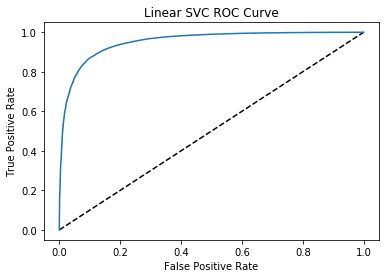

ROC AUC Score : 0.9521716303672814


In [16]:
y_pred_prob = cclf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label="positive")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Linear SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVC ROC Curve')
plt.show();
print("ROC AUC Score :", roc_auc_score(y_test, y_pred_prob))